# Timeseries and histograms

Callback-functions can be used to trigger updates on other plots.
This example shows how to use EOmaps to analyze a database that is associated with a map.

- create a grid of ``Maps`` objects and ordinary matplotlib axes via ``MapsGrid``
- define a custom callback to update the plots if you click on the map


![image](../../../_static/example_images/example_timeseries.gif)

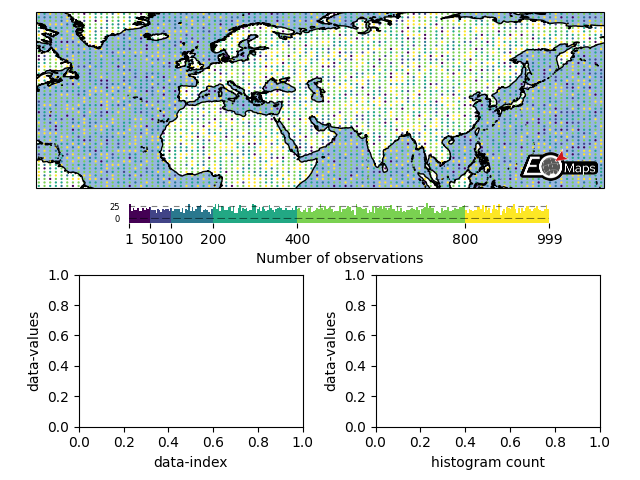

In [1]:
# EOmaps example:  Data analysis widgets - Interacting with a database

from eomaps import Maps
import pandas as pd
import numpy as np

# ============== create a random database =============
length, Nlon, Nlat = 1000, 100, 50
lonmin, lonmax, latmin, latmax = -70, 175, 0, 75

database = np.full((Nlon * Nlat, length), np.nan)
for i in range(Nlon * Nlat):
    size = np.random.randint(1, length)
    x = np.random.normal(loc=np.random.rand(), scale=np.random.rand(), size=size)
    np.put(database, range(i * length, i * length + size), x)
lon, lat = np.meshgrid(
    np.linspace(lonmin, lonmax, Nlon), np.linspace(latmin, latmax, Nlat)
)

IDs = [f"point_{i}" for i in range(Nlon * Nlat)]
database = pd.DataFrame(database, index=IDs)
coords = pd.DataFrame(dict(lon=lon.flat, lat=lat.flat), index=IDs)

# -------- calculate the number of values in each dataset
#          (e.g. the data actually shown on the map)
data = pd.DataFrame(dict(count=database.count(axis=1), **coords))
# =====================================================


# initialize a map on top
m = Maps(ax=211)
m.add_feature.preset.ocean()
m.add_feature.preset.coastline()

# initialize 2 matplotlib plot-axes below the map
ax_left = m.f.add_subplot(223)
ax_left.set_ylabel("data-values")
ax_left.set_xlabel("data-index")

ax_right = m.f.add_subplot(224)
ax_right.set_ylabel("data-values")
ax_right.set_xlabel("histogram count")

ax_left.sharey(ax_right)

# -------- assign data to the map and plot it
m.set_data(data=data, x="lon", y="lat", crs=4326)
m.set_classify_specs(
    scheme=Maps.CLASSIFIERS.UserDefined,
    bins=[50, 100, 200, 400, 800],
)
m.set_shape.ellipses(radius=0.5)
m.plot_map()


# -------- define a custom callback function to update the plots
def update_plots(ID, **kwargs):
    # get the data
    x = database.loc[ID].dropna()

    # plot the lines and histograms
    (l,) = ax_left.plot(x, lw=0.5, marker=".", c="C0")
    cnt, val, art = ax_right.hist(x.values, bins=50, orientation="horizontal", fc="C0")

    # re-compute axis limits based on the new artists
    ax_left.relim()
    ax_right.relim()
    ax_left.autoscale()
    ax_right.autoscale()

    # add all artists as "temporary pick artists" so that they
    # are removed when the next datapoint is selected
    for a in [l, *art]:
        m.cb.pick.add_temporary_artist(a)


# attach the custom callback (and some pre-defined callbacks)
m.cb.pick.attach(update_plots)
m.cb.pick.attach.annotate()
m.cb.pick.attach.mark(permanent=False, buffer=1, fc="none", ec="r")
m.cb.pick.attach.mark(permanent=False, buffer=2, fc="none", ec="r", ls=":")

# add a colorbar
m.add_colorbar(0.25, label="Number of observations")
m.colorbar.ax_cb_plot.tick_params(labelsize=6)

# add a logo
m.add_logo()

m.apply_layout(
    {
        "figsize": [6.4, 4.8],
        "0_map": [0.05625, 0.60894, 0.8875, 0.36594],
        "1_": [0.12326, 0.11123, 0.35, 0.31667],
        "2_": [0.58674, 0.11123, 0.35, 0.31667],
        "3_cb": [0.12, 0.51667, 0.82, 0.06166],
        "3_cb_histogram_size": 0.8,
        "4_logo": [0.8125, 0.62333, 0.1212, 0.06667],
    }
)
m.show()